In [1]:
import pandas as pd
from pandas_datareader import data
import numpy as np
import matplotlib.pyplot as plt
from warnings import filterwarnings
from cycler import cycler

plt.style.use(['dark_background', 'fivethirtyeight'])
plt.rcParams['axes.facecolor'] = '#121212'
plt.rcParams['figure.facecolor'] = '#121212'
plt.rcParams['grid.linestyle'] = ':'
plt.rcParams['figure.autolayout'] = True ## This makes sure that the subplots are sufficiently far apart
plt.rcParams['axes.prop_cycle'] = cycler('color',['#bb86fc', '#c7fc86', '#ff7697', '#ffffff'])
plt.rcParams['lines.linewidth'] = 2
plt.rcParams['boxplot.boxprops.linewidth'] = 2 
plt.rcParams['boxplot.flierprops.markeredgecolor'] = 'white'

filterwarnings('ignore')

/usr/local/anaconda3/envs/EDA/lib/python3.8/site-packages/pandas_datareader/compat/__init__.py:7: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  from pandas.util.testing import assert_frame_equal


## Data scraping and prep

We first download the tickers of the S&P100 index from Wikipedia and use that to read the data of stock prices

In [2]:
try:
    tickers = pd.read_csv('tickers_sp100.csv')
except FileNotFoundError:    
    website_data = pd.read_html('https://en.wikipedia.org/wiki/S%26P_100')
    tickers = website_data[2].Symbol # this is the ticker table
    tickers.to_csv('tickers_sp100.csv', index=False)
    
tickers = tickers.Symbol.to_list()

In [3]:
start_date = '2015-05-31'
end_date = '2020-05-31'

try:
    raw_data = pd.read_pickle('sp100_adj_close.pkl')
except FileNotFoundError:
    raw_data = pd.DataFrame()
    
    print('Downloading started:')
    print('-'*50)
    
    for i, ticker in enumerate(tickers):
        try:
            col = data.DataReader(ticker, 'yahoo', start_date, end_date)['Adj Close']
            raw_data[ticker] = col
        except:
            print(f'Could not retrieve the data for {ticker}')
      
    print('Downloading complete!')
    print('-'*50)
    
    raw_data.to_pickle('sp100_adj_close.pkl')
        

## Data cleaning

There are a few columns with missing values. Since this is an exploratory exercise we will just drop the columns and not worry about imputing the values.

In [4]:
raw_data.columns[raw_data.isna().any()]

Index(['DOW', 'KHC', 'PYPL'], dtype='object')

In [5]:
data = raw_data[raw_data.columns[raw_data.isna().any() == False]]
data.isna().sum().sum()

0

There are no more missing values. We compute the returns. 

In [19]:
returns = data.diff().dropna()
returns.to_pickle('sp100_clean_returns.pkl')
returns.shape

(1258, 97)

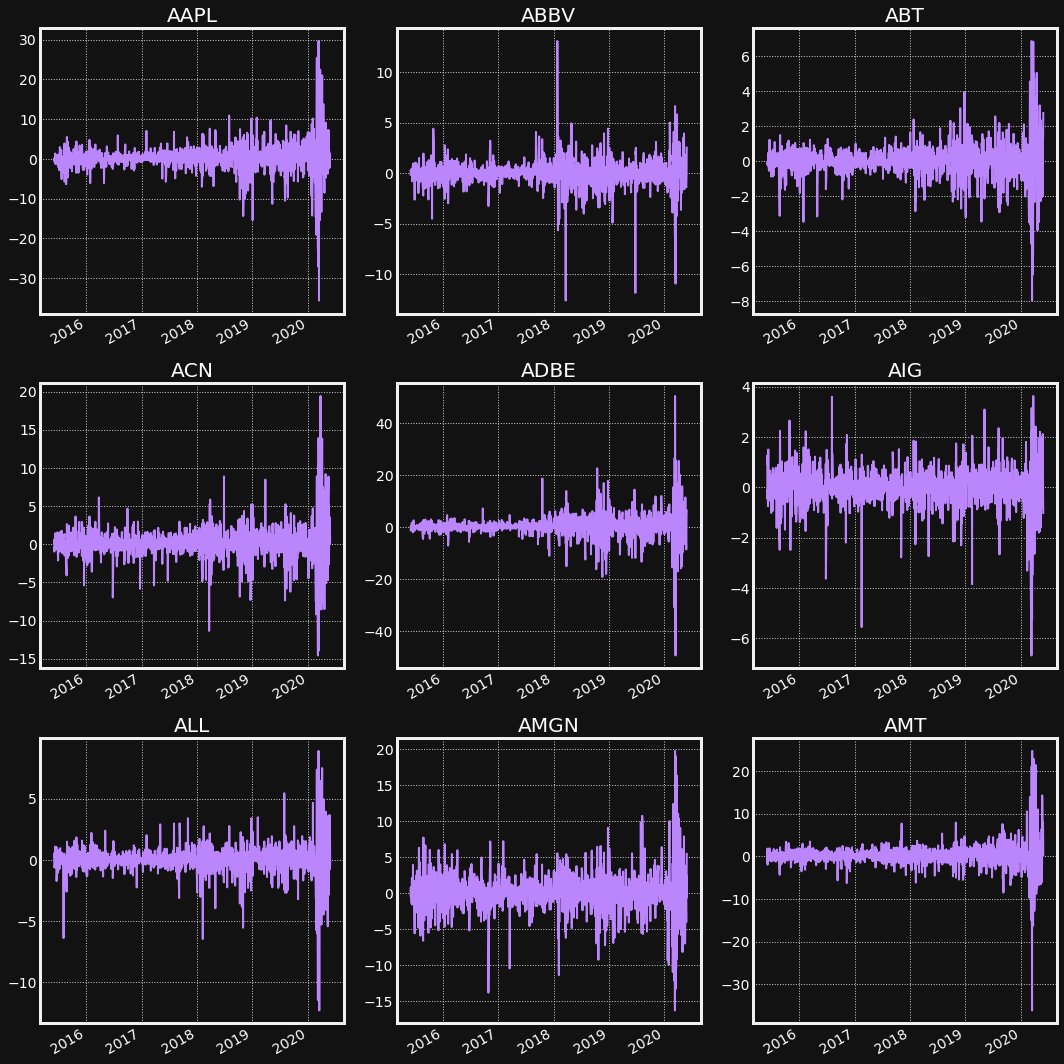

In [7]:
fig, axs = plt.subplots(3,3, figsize = (15,15))
axs = axs.ravel()

for i, elt in enumerate(returns.columns[:9]):
    returns[elt].plot(ax=axs[i], title = elt)
    axs[i].set_xlabel('')
    

## PCA

We will start by standardizing the returns and then perform the principal component analysis that extracts the principal directions explaining the variation of the data.  

In [8]:
import seaborn as sns

from sklearn import preprocessing
from sklearn.decomposition import PCA 

In [9]:
returns.corr().describe()

,AAPL,ABBV,ABT,ACN,ADBE,AIG,ALL,AMGN,AMT,AMZN,...,UNH,UNP,UPS,USB,V,VZ,WBA,WFC,WMT,XOM
count,97.000000,97.000000,97.000000,97.000000,97.000000,97.000000,97.000000,97.000000,97.000000,97.000000,...,97.000000,97.000000,97.000000,97.000000,97.000000,97.000000,97.000000,97.000000,97.000000,97.000000
mean,0.531264,0.378674,0.508893,0.562100,0.503261,0.454920,0.513698,0.465205,0.432706,0.397383,...,0.476741,0.501853,0.443771,0.539602,0.570455,0.391878,0.350792,0.495379,0.366032,0.452777
std,0.113361,0.090244,0.106365,0.107959,0.129002,0.119556,0.106225,0.094086,0.134488,0.127685,...,0.095078,0.117413,0.092081,0.134635,0.126718,0.108354,0.087312,0.130895,0.111861,0.113732
min,0.324330,0.221490,0.281401,0.309304,0.262510,0.245489,0.287494,0.276856,0.166275,0.220814,...,0.267870,0.264933,0.300484,0.277221,0.303463,0.177084,0.230527,0.282882,0.136625,0.258654
25%,0.461936,0.330753,0.447804,0.501075,0.421922,0.376795,0.456786,0.414924,0.335977,0.322548,...,0.421451,0.415115,0.382171,0.452625,0.500173,0.330833,0.306091,0.408163,0.303148,0.373597
50%,0.530572,0.372319,0.506766,0.563508,0.489493,0.446416,0.515612,0.459183,0.433674,0.384170,...,0.488860,0.511105,0.438932,0.521242,0.563725,0.380431,0.349878,0.473967,0.350956,0.446561
75%,0.596266,0.418036,0.571777,0.640040,0.567121,0.517924,0.577661,0.511145,0.517558,0.436551,...,0.522551,0.578158,0.496969,0.583008,0.647981,0.442043,0.385444,0.538318,0.427256,0.505524
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


## Standardizing the returns

We standardize the returns by making them centered at 0 with variance 1 using sklearn scaler

In [10]:
standard_returns = pd.DataFrame(preprocessing.scale(returns), index = returns.index, columns = returns.columns)

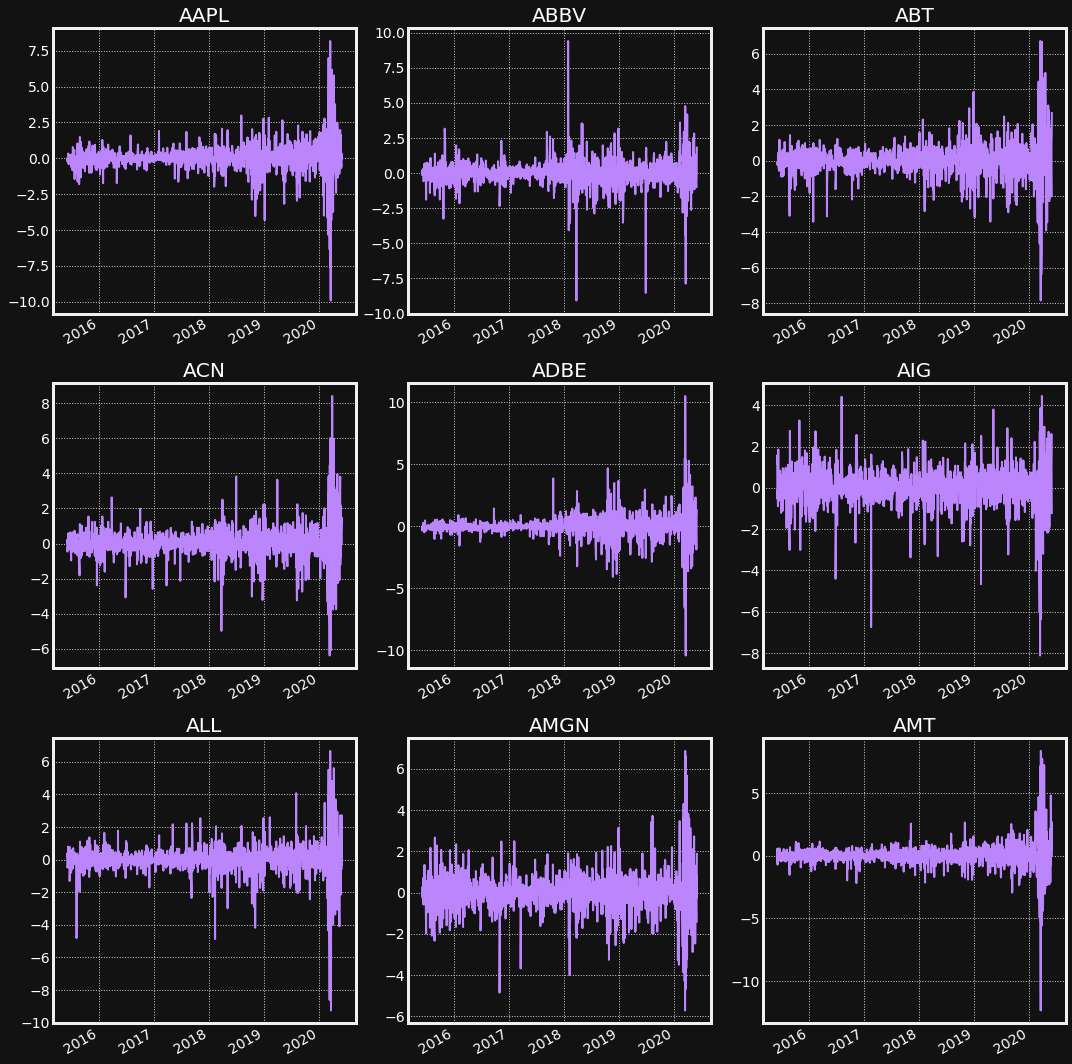

In [11]:
fig, axs = plt.subplots(3,3, figsize = (15,15))
axs = axs.ravel()

for i, elt in enumerate(standard_returns.columns[:9]):
    standard_returns[elt].plot(ax=axs[i], title = elt)
    axs[i].set_xlabel('')
    

In [26]:
pca_model = PCA(n_components=20)
pca_model.fit(standard_returns)

PCA(copy=True, iterated_power='auto', n_components=20, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

Text(0.5, 1.0, 'Variance explained')

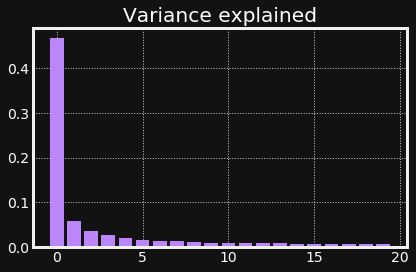

In [28]:
plt.bar(range(20),pca_model.explained_variance_ratio_)
plt.title('Variance explained')

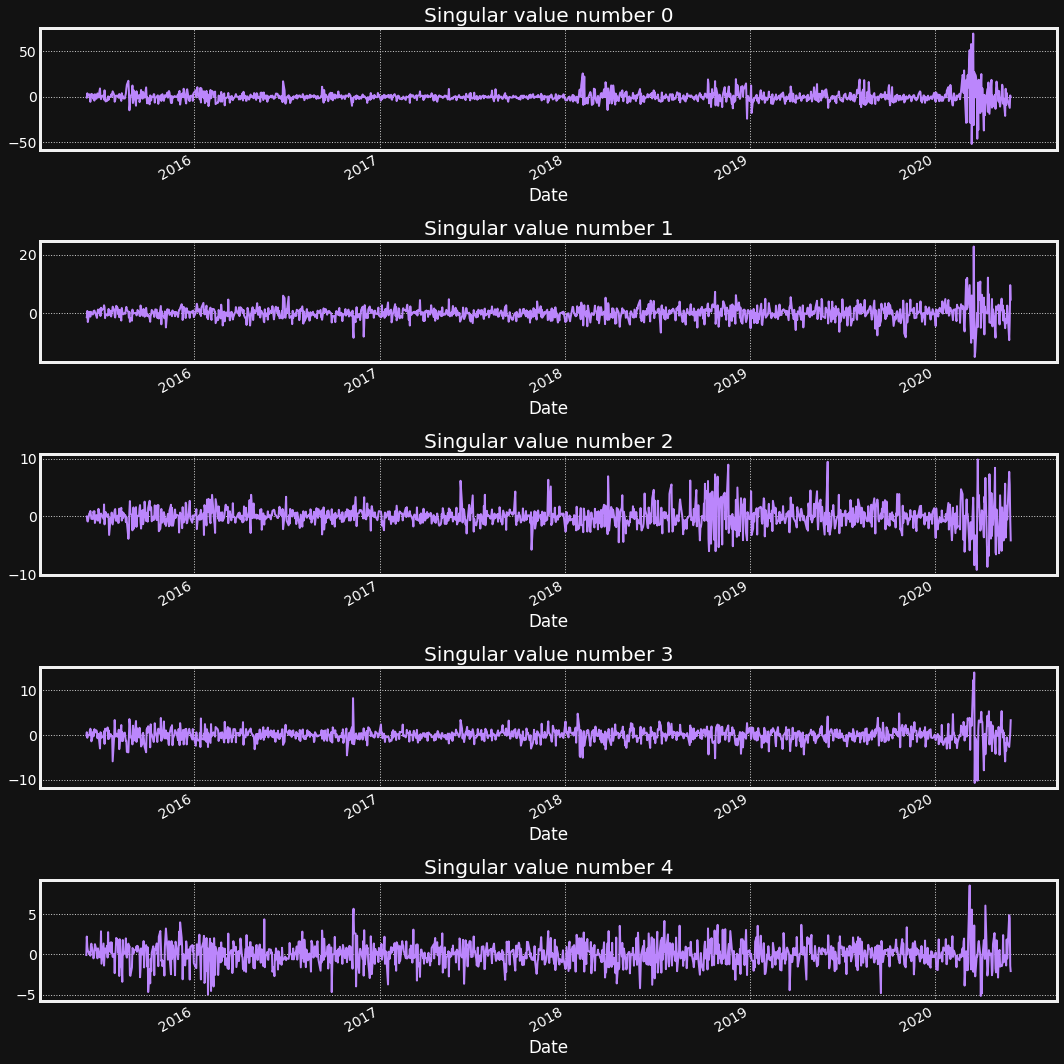

In [48]:
reduced_returns = pd.DataFrame(pca_model.transform(standard_returns), index=standard_returns.index)


fig, axs = plt.subplots(5,1, figsize = (15,15))
axs = axs.ravel()

for i in range(5):
    reduced_returns[i].plot(ax=axs[i])
    axs[i].set_title(f'Singular value number {i}')

In [52]:
import denoising_detoning as dd

In [54]:
x = dd.mpPDF(1, 1258/97, 1000)

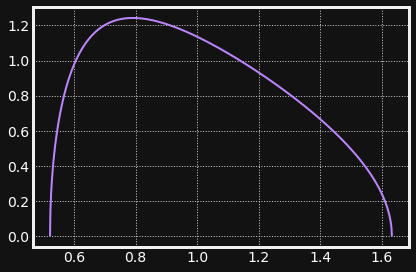

In [55]:
x.plot()

In [60]:
eVal, eVec = dd.getPCA(standard_returns.corr())

In [74]:
pdf1 = dd.fitKDE(np.diag(eVal))

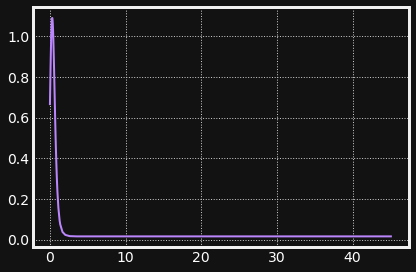

In [75]:
pdf1.plot()

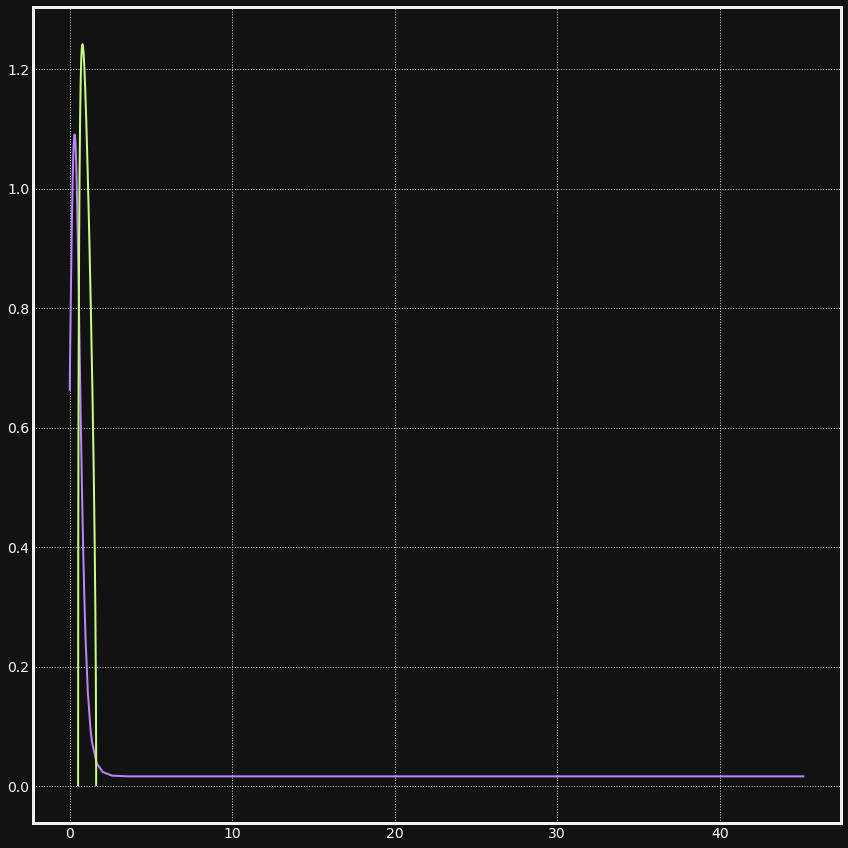

In [76]:
fig, ax = plt.subplots(1,1,figsize=(12,12))
pdf1.plot(ax=ax)
x.plot(ax=ax)